# Import dataset
Si importano le maggiori librerie e il dataset, si rimuove la riga della colonne degli indici e si stampa a video. 
Dataset originale: [UFO Sightings](https://www.kaggle.com/datasets/NUFORC/ufo-sightings)  
Espansione con dati meteo: [API Meteo](https://open-meteo.com/en/docs/historical-weather-api)

Obiettivo analisi:
 - Esiste una correlazione tra gli avvistamenti UFO e determinate condizioni meteorologiche?
 - Si possono raggruppare gli avvistamenti in base ai dati presenti nel dataset?
 - Quali sono le tendenze degli avvistamenti negli anni? 
 - Dalle analisi condotte è possibile dare una spiegazione agli avvistamenti presenti nel dataset?

In [1]:
import pandas as pd
import numpy as np
import requests
import json
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.stats import chi2_contingency
from statsmodels.formula.api import ols
from ucimlrepo import fetch_ucirepo
from sklearn.metrics import silhouette_score
from statsmodels.formula.api import logit
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

df_ufo=pd.read_csv('dataset/nuovo.csv')
df_ufo=df_ufo.drop('Unnamed: 0', axis=1)

avv1 = df_ufo[df_ufo['avvistamento'] == 1]
avv0 = df_ufo[df_ufo['avvistamento'] == 0]
df_ufo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125710 entries, 0 to 125709
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   datetime              125710 non-null  object 
 1   city                  125710 non-null  object 
 2   state                 125710 non-null  object 
 3   country               125710 non-null  object 
 4   shape                 125710 non-null  object 
 5   duration_seconds      125710 non-null  float64
 6   duration_hour_min     125710 non-null  object 
 7   comments              125710 non-null  object 
 8   date_posted           125710 non-null  object 
 9   latitude              125710 non-null  float64
 10  longitude             125710 non-null  float64
 11  temperatura           125710 non-null  float64
 12  precipitazioni        125710 non-null  float64
 13  pressione_superficie  125710 non-null  float64
 14  copertura_nuvole      125710 non-null  int64  
 15  

# Visualizzazione dati meteo
Si visualizzano gli istogrammi dei dati meteo recuperati, si mostra nell'asse x i valori delle variabili e nell'asse y la quantità di elementi che ricadono nel singolo bin.


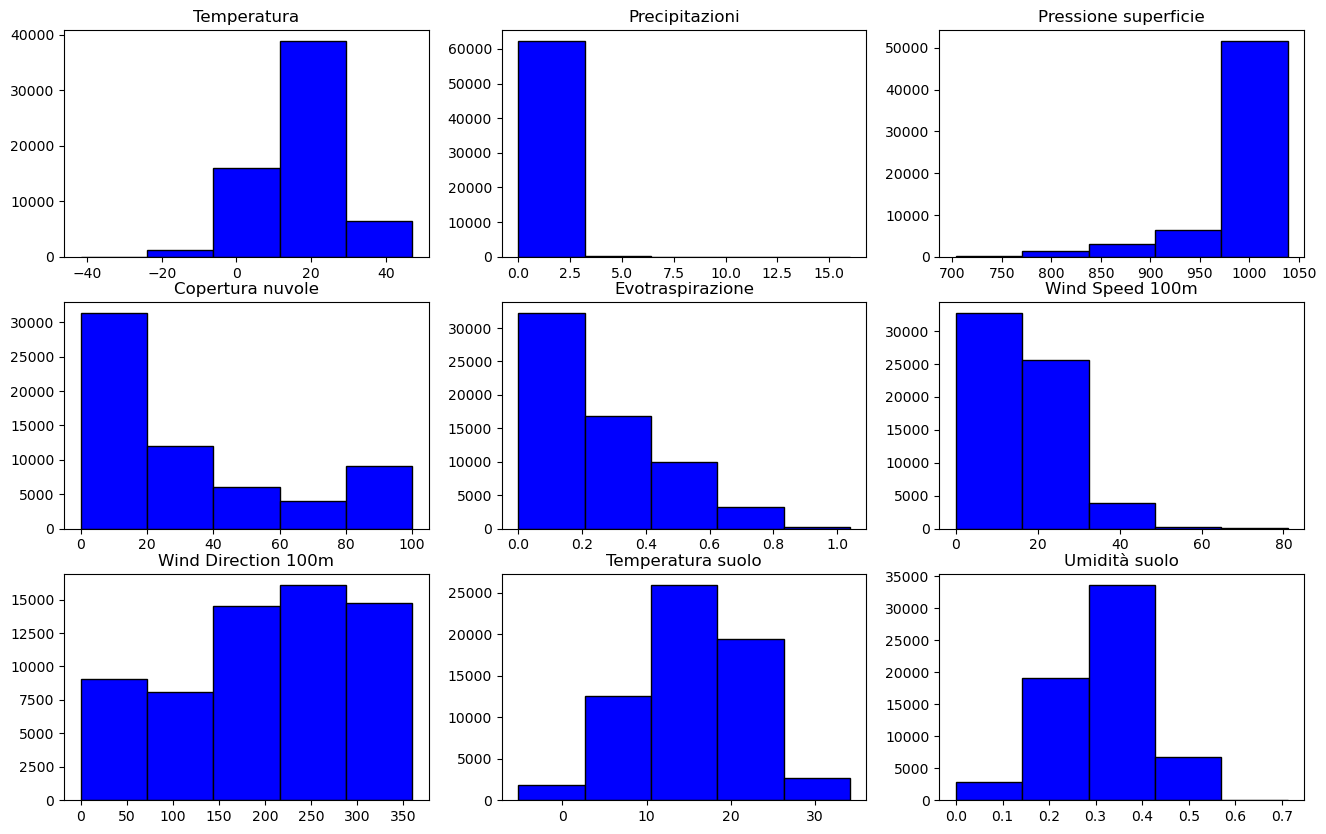

In [2]:
plt.figure(figsize=(16,10))

plt.subplot(3,3,1)
plt.hist(avv1['temperatura'], bins=5, color='blue', edgecolor='black')
plt.title('Temperatura')

plt.subplot(3,3,2)
plt.hist(avv1['precipitazioni'], bins=5, color='blue', edgecolor='black')
plt.title('Precipitazioni')

plt.subplot(3,3,3)
plt.hist(avv1['pressione_superficie'], bins=5, color='blue', edgecolor='black')
plt.title('Pressione superficie')

plt.subplot(3,3,4)
plt.hist(avv1['copertura_nuvole'], bins=5, color='blue', edgecolor='black')
plt.title('Copertura nuvole')

plt.subplot(3,3,5)
plt.hist(avv1['evotraspirazione'], bins=5, color='blue', edgecolor='black')
plt.title('Evotraspirazione')

plt.subplot(3,3,6)
plt.hist(avv1['wind_speed_100m'], bins=5, color='blue', edgecolor='black')
plt.title('Wind Speed 100m')

plt.subplot(3,3,7)
plt.hist(avv1['wind_direction_100m'], bins=5, color='blue', edgecolor='black')
plt.title('Wind Direction 100m')

plt.subplot(3,3,8)
plt.hist(avv1['temperatura_suolo'], bins=5, color='blue', edgecolor='black')
plt.title('Temperatura suolo')

plt.subplot(3,3,9)
plt.hist(avv1['umidita_suolo'], bins=5, color='blue', edgecolor='black')
plt.title('Umidità suolo')

plt.show()

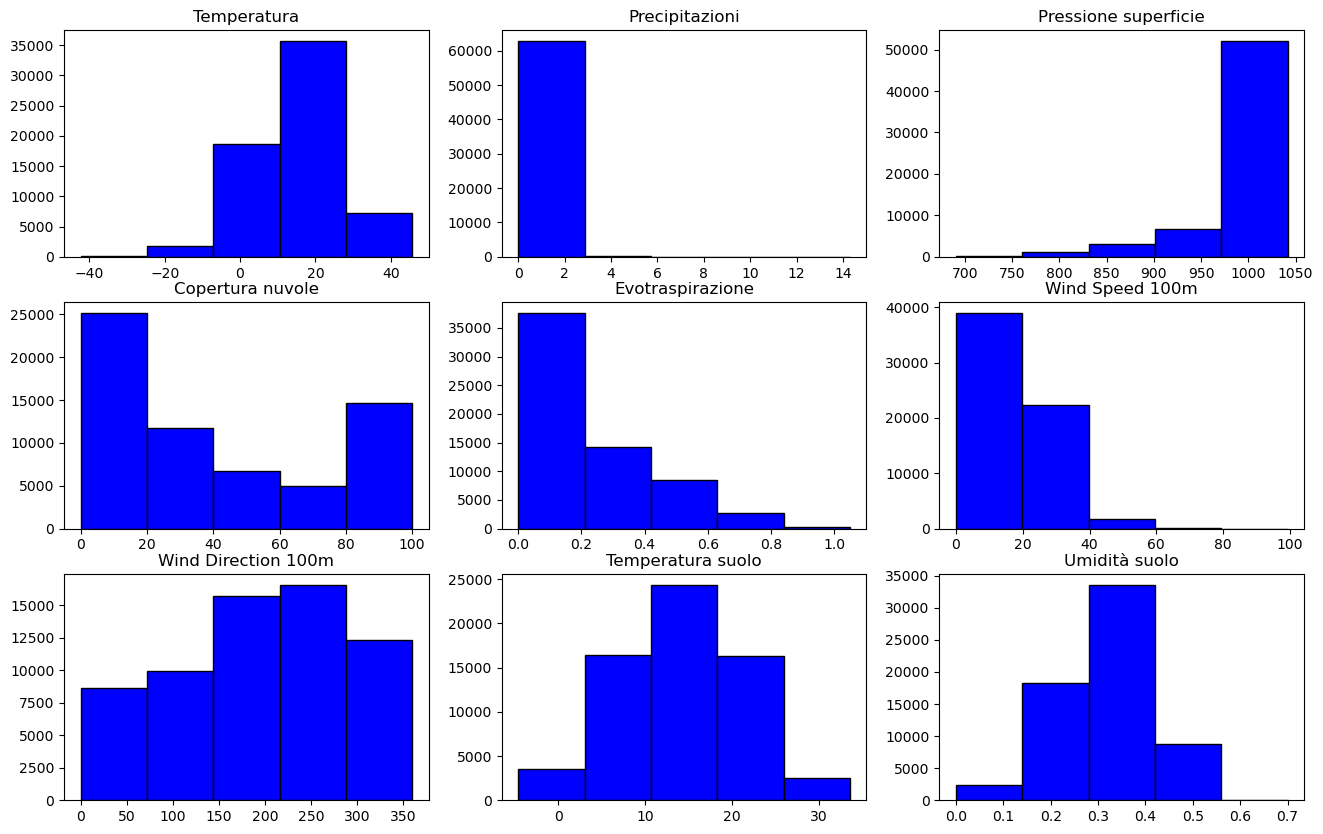

In [3]:
plt.figure(figsize=(16,10))

plt.subplot(3,3,1)
plt.hist(df_ufo[df_ufo['avvistamento'] == 0]['temperatura'], bins=5, color='blue', edgecolor='black')
plt.title('Temperatura')

plt.subplot(3,3,2)
plt.hist(df_ufo[df_ufo['avvistamento'] == 0]['precipitazioni'], bins=5, color='blue', edgecolor='black')
plt.title('Precipitazioni')

plt.subplot(3,3,3)
plt.hist(df_ufo[df_ufo['avvistamento'] == 0]['pressione_superficie'], bins=5, color='blue', edgecolor='black')
plt.title('Pressione superficie')

plt.subplot(3,3,4)
plt.hist(df_ufo[df_ufo['avvistamento'] == 0]['copertura_nuvole'], bins=5, color='blue', edgecolor='black')
plt.title('Copertura nuvole')

plt.subplot(3,3,5)
plt.hist(df_ufo[df_ufo['avvistamento'] == 0]['evotraspirazione'], bins=5, color='blue', edgecolor='black')
plt.title('Evotraspirazione')

plt.subplot(3,3,6)
plt.hist(df_ufo[df_ufo['avvistamento'] == 0]['wind_speed_100m'], bins=5, color='blue', edgecolor='black')
plt.title('Wind Speed 100m')

plt.subplot(3,3,7)
plt.hist(df_ufo[df_ufo['avvistamento'] == 0]['wind_direction_100m'], bins=5, color='blue', edgecolor='black')
plt.title('Wind Direction 100m')

plt.subplot(3,3,8)
plt.hist(df_ufo[df_ufo['avvistamento'] == 0]['temperatura_suolo'], bins=5, color='blue', edgecolor='black')
plt.title('Temperatura suolo')

plt.subplot(3,3,9)
plt.hist(df_ufo[df_ufo['avvistamento'] == 0]['umidita_suolo'], bins=5, color='blue', edgecolor='black')
plt.title('Umidità suolo')

plt.show()

# Grafico avvistamenti città


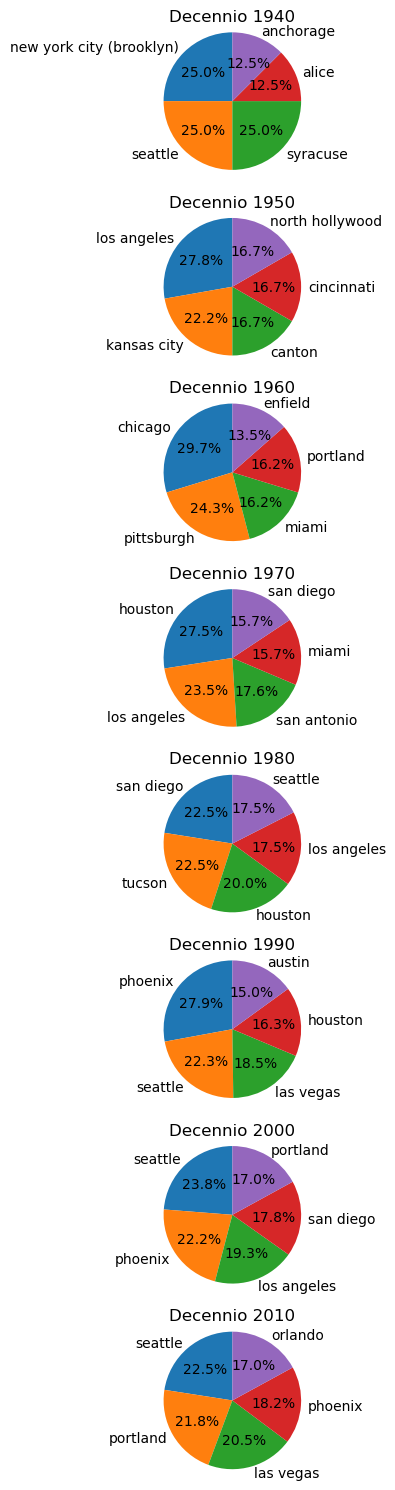

In [4]:
shape = avv1.groupby(['decennio', 'city']).size()

decenni = len(shape.index.levels[0])
fig, axs = plt.subplots(decenni, figsize=(15, 15))

plt.subplots_adjust(hspace=10)

for i, decennio in enumerate(shape.index.levels[0]):
    ax = axs[i]
    shapes = shape.loc[decennio]
    
    hight_shapes = shapes.nlargest(5)
    ax.pie(hight_shapes, labels=hight_shapes.index, autopct='%1.1f%%', startangle=90, radius=1.2)
    ax.set_title(f'Decennio {decennio}')

plt.tight_layout()
plt.show()

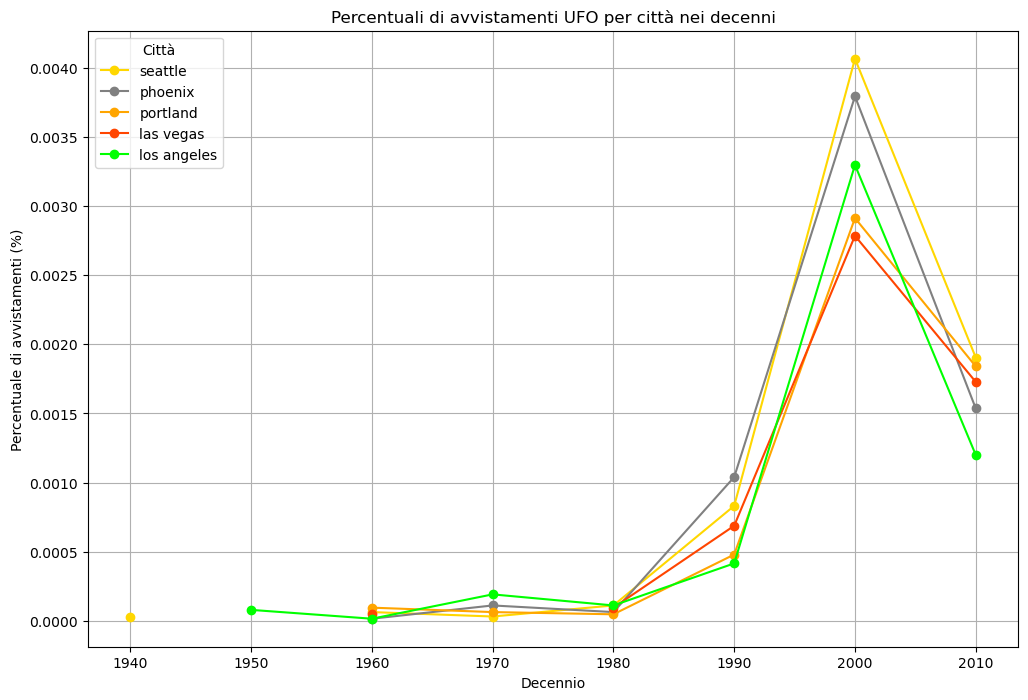

In [5]:
decennio_citta = (avv1.groupby(['decennio', 'city']).size() / len(avv1)).unstack()
top_city = decennio_citta.sum().nlargest(5).index
migliori_citta = decennio_citta[top_city]
colori = {
    'seattle': '#FFD700',  
    'phoenix': '#808080',  
    'portland': '#FFA500', 
    'las vegas': '#FF4500',  
    'los angeles': '#00FF00'
}
plt.figure(figsize=(12, 8))
for forma in migliori_citta.columns:
    plt.plot(migliori_citta.index, migliori_citta[forma], marker='o', color=colori[forma])

plt.title('Percentuali di avvistamenti UFO per città nei decenni')
plt.xlabel('Decennio')
plt.ylabel('Percentuale di avvistamenti (%)')
plt.legend(title='Città', labels=colori.keys())
plt.grid(True)
plt.show()

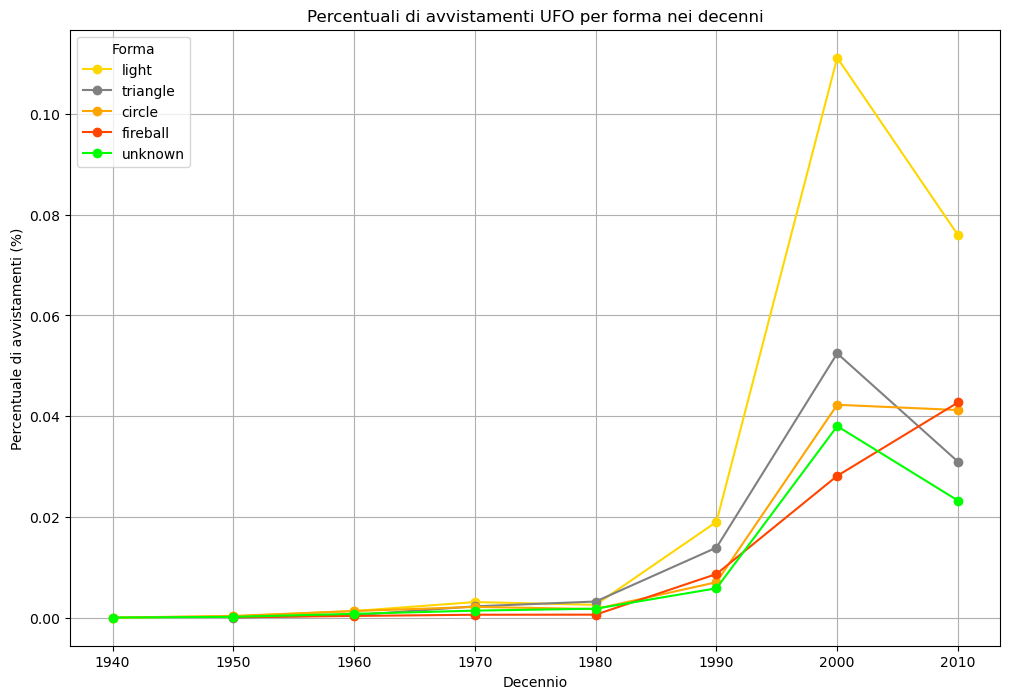

In [6]:
decennio_citta = (avv1.groupby(['decennio', 'shape']).size() / len(avv1)).unstack()
top_shapes = decennio_citta.sum().nlargest(5).index
migliori_forme = decennio_citta[top_shapes]
colori = {
    'light': '#FFD700', 
    'triangle': '#808080', 
    'circle': '#FFA500',  
    'fireball': '#FF4500',  
    'unknown': '#00FF00' 
}
plt.figure(figsize=(12, 8))
for forma in migliori_forme.columns:
    plt.plot(migliori_forme.index, migliori_forme[forma], marker='o', color=colori[forma])

plt.title('Percentuali di avvistamenti UFO per forma nei decenni')
plt.xlabel('Decennio')
plt.ylabel('Percentuale di avvistamenti (%)')
plt.legend(title='Forma', labels=colori.keys())
plt.grid(True)
plt.show()


# Grafico avvistamenti forma

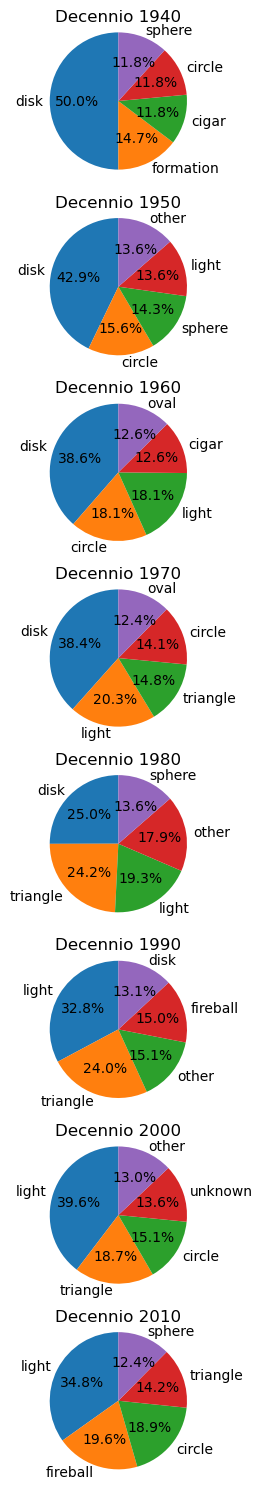

In [7]:
forme = avv1.groupby(['decennio', 'shape']).size()

decenni = len(forme.index.levels[0])
fig, axs = plt.subplots(decenni, figsize=(15, 15))

plt.subplots_adjust(hspace=10)

for i, decennio in enumerate(forme.index.levels[0]):
    ax = axs[i]
    shapes = forme.loc[decennio]
    
    migliori_forme = shapes.nlargest(5)
    ax.pie(migliori_forme, labels=migliori_forme.index, autopct='%1.1f%%', startangle=90, radius=1.2)
    ax.set_title(f'Decennio {decennio}')

plt.tight_layout()
plt.show()

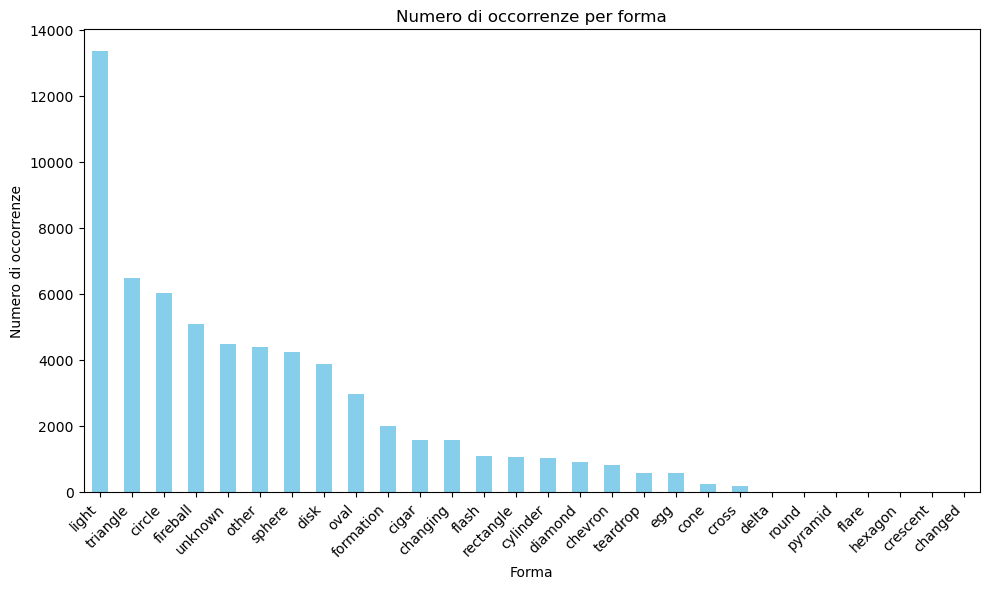

In [8]:
forma_count = avv1['shape'].value_counts()
plt.figure(figsize=(10, 6))
forma_count.plot(kind='bar', color='skyblue')
plt.title('Numero di occorrenze per forma')
plt.xlabel('Forma')
plt.ylabel('Numero di occorrenze')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Medie delle durate degli avvistamenti raggrupate per decennio
Nell'asse x i decenni, nell'asse y la media della durata dell'avvistamento. 

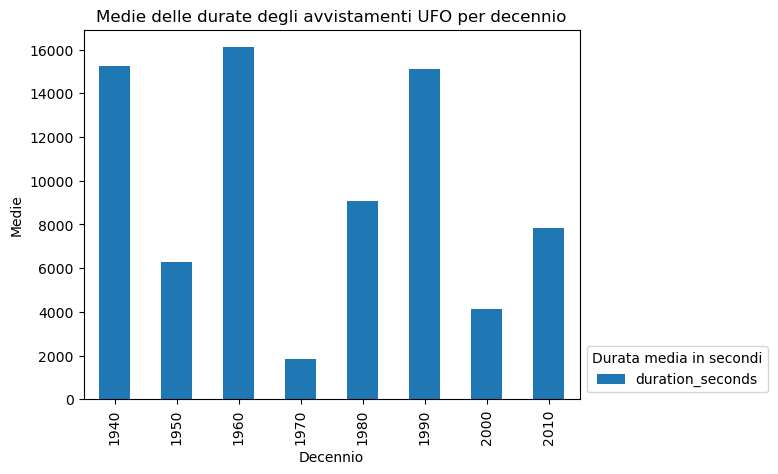

In [9]:
media_decennio = avv1.groupby('decennio')['duration_seconds'].mean()
media_decennio.plot(kind='bar')
plt.xlabel('Decennio')
plt.ylabel('Medie')
plt.title('Medie delle durate degli avvistamenti UFO per decennio')
plt.legend(title='Durata media in secondi', loc='lower left', bbox_to_anchor=(1.0, 0.0))
plt.show()

# Media dati meteo raggruppati per avvistamenti e non avvistamenti
Si riscontano dati meteorologici migliori in casi di avvistamento UFO, gli avvistamenti hanno una temperatura maggiore. una minore copertura nuvole, una minore percentuale di precipitazioni e una velocità del vento minore rispetto ai dati meteo dei non avvistamenti.


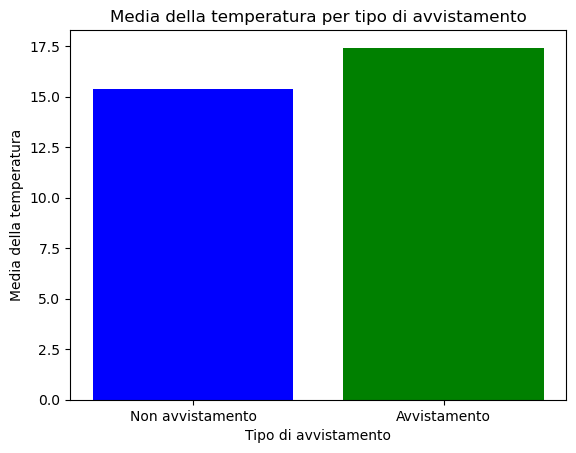

In [10]:
media_0 = avv0['temperatura'].mean()
media_1 = avv1['temperatura'].mean()

medie = [media_0, media_1]

etichette = ['Non avvistamento', 'Avvistamento']

plt.bar(etichette, medie, color=['blue', 'green'])

plt.title('Media della temperatura per tipo di avvistamento')
plt.xlabel('Tipo di avvistamento')
plt.ylabel('Media della temperatura')

plt.show()

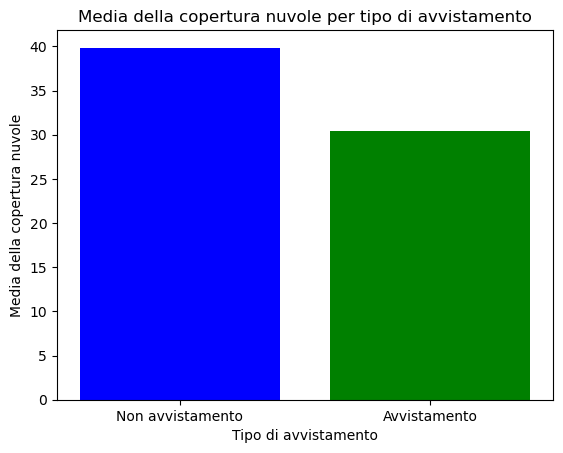

In [11]:
media_0 = avv0['copertura_nuvole'].mean()
media_1 = avv1['copertura_nuvole'].mean()

medie = [media_0, media_1]

etichette = ['Non avvistamento', 'Avvistamento']

plt.bar(etichette, medie, color=['blue', 'green'])

plt.title('Media della copertura nuvole per tipo di avvistamento')
plt.xlabel('Tipo di avvistamento')
plt.ylabel('Media della copertura nuvole')

plt.show()

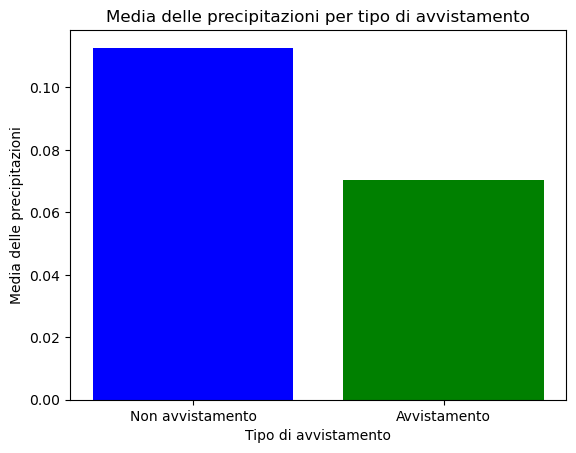

In [12]:
media_0 = avv0['precipitazioni'].mean()
media_1 = avv1['precipitazioni'].mean()

medie = [media_0, media_1]

etichette = ['Non avvistamento', 'Avvistamento']

plt.bar(etichette, medie, color=['blue', 'green'])

plt.title('Media delle precipitazioni per tipo di avvistamento')
plt.xlabel('Tipo di avvistamento')
plt.ylabel('Media delle precipitazioni')

plt.show()

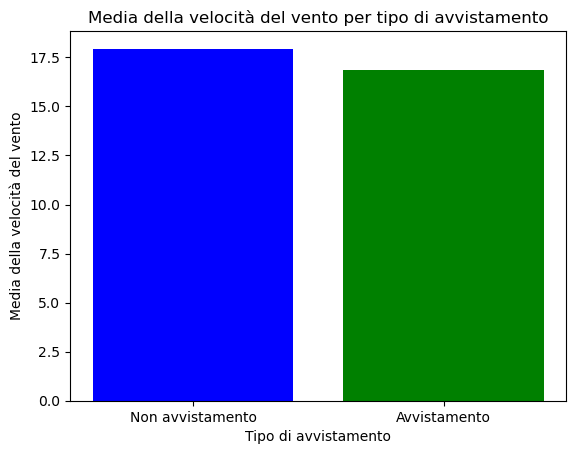

In [13]:
media_0 = avv0['wind_speed_100m'].mean()
media_1 = avv1['wind_speed_100m'].mean()

medie = [media_0, media_1]

etichette = ['Non avvistamento', 'Avvistamento']

plt.bar(etichette, medie, color=['blue', 'green'])

plt.title('Media della velocità del vento per tipo di avvistamento')
plt.xlabel('Tipo di avvistamento')
plt.ylabel('Media della velocità del vento')

plt.show()

# Durata media degli avvistamenti raggruppata per forma
Nell'asse x la forma dell'avvistamento, nell'asse y la durata della forma.

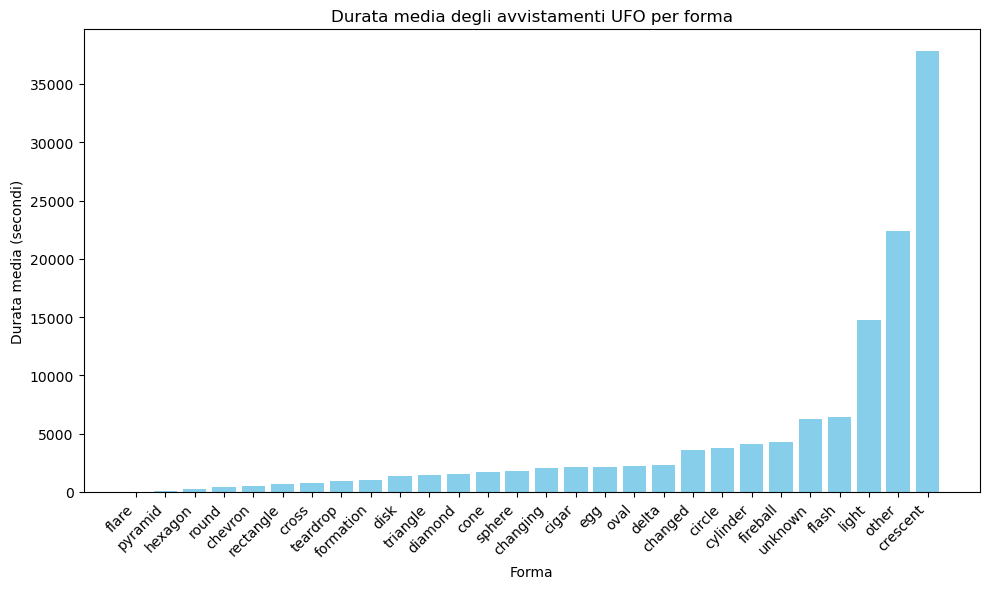

In [14]:
froma_durata_media = avv1.groupby('shape')['duration_seconds'].mean().sort_values()

plt.figure(figsize=(10, 6))
plt.bar(froma_durata_media.index, froma_durata_media.values, color='skyblue')

plt.xlabel('Forma')
plt.ylabel('Durata media (secondi)')
plt.title('Durata media degli avvistamenti UFO per forma')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Livello di precipitazioni raggruppati per forma
Nell'asse x la forma dell'avvistamento, nell'asse y la percentuale di precipitazioni.

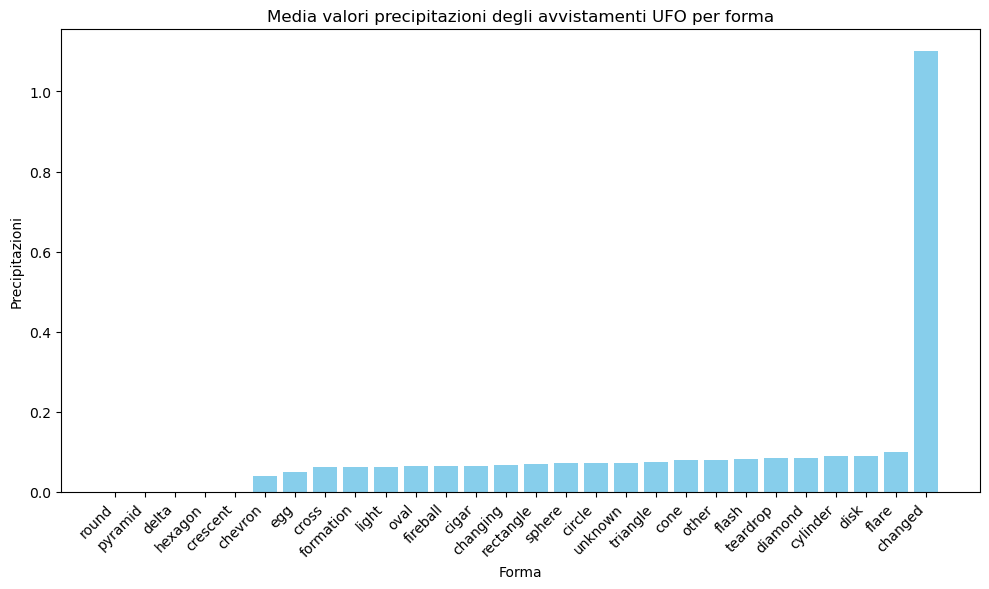

In [15]:
froma_precipitazioni_media = avv1.groupby('shape')['precipitazioni'].mean().sort_values()

plt.figure(figsize=(10, 6))
plt.bar(froma_precipitazioni_media.index, froma_precipitazioni_media.values, color='skyblue')

plt.xlabel('Forma')
plt.ylabel('Precipitazioni')
plt.title('Media valori precipitazioni degli avvistamenti UFO per forma')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Media valori copertura nuvole degli avvistamenti UFO per forma
Nell'asse x la forma dell'avvistamento, nell'asse y la percentuale di copertura nuvole.

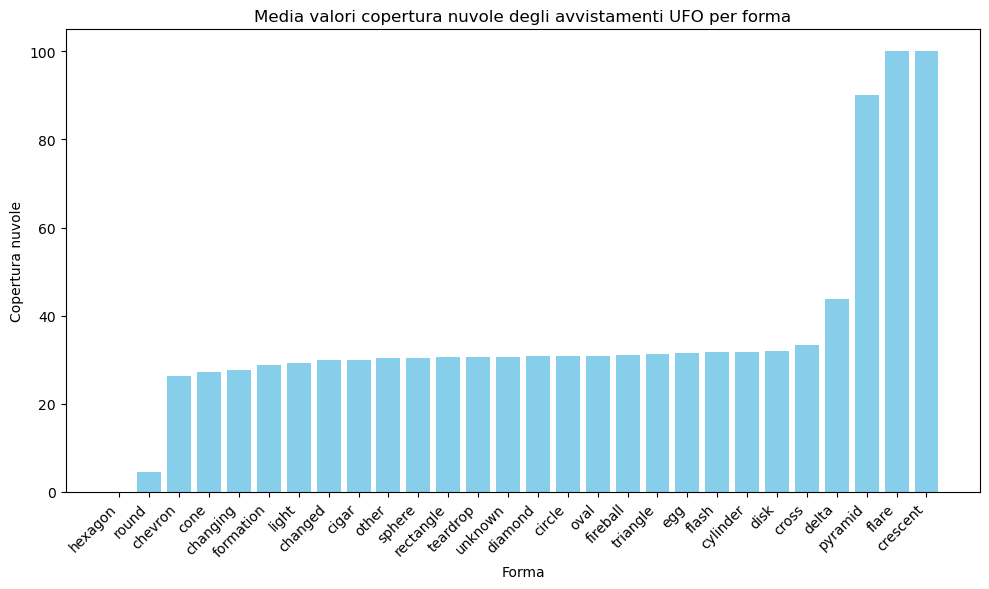

In [16]:
forma_coperturanuvole_media = avv1.groupby('shape')['copertura_nuvole'].mean().sort_values()

plt.figure(figsize=(10, 6))
plt.bar(forma_coperturanuvole_media.index, forma_coperturanuvole_media.values, color='skyblue')

plt.xlabel('Forma')
plt.ylabel('Copertura nuvole')
plt.title('Media valori copertura nuvole degli avvistamenti UFO per forma')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Media valori precipitazioni degli avvistamenti UFO per forma
Nell'asse x la forma dell'avvistamento, nell'asse y la percentuale di precipitazioni.

# Distribuzione degli avvistamenti per ora del giorno
Nell'asse x l'ora del giorno, nell'asse y il numero degli avvistamenti. Si può notare che la maggior parte degli avvistamenti si riscontrano nelle ore buie.

C:\Users\dcocu\AppData\Local\Temp\ipykernel_17956\1004367825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avv1['hour'] = orario.dt.hour


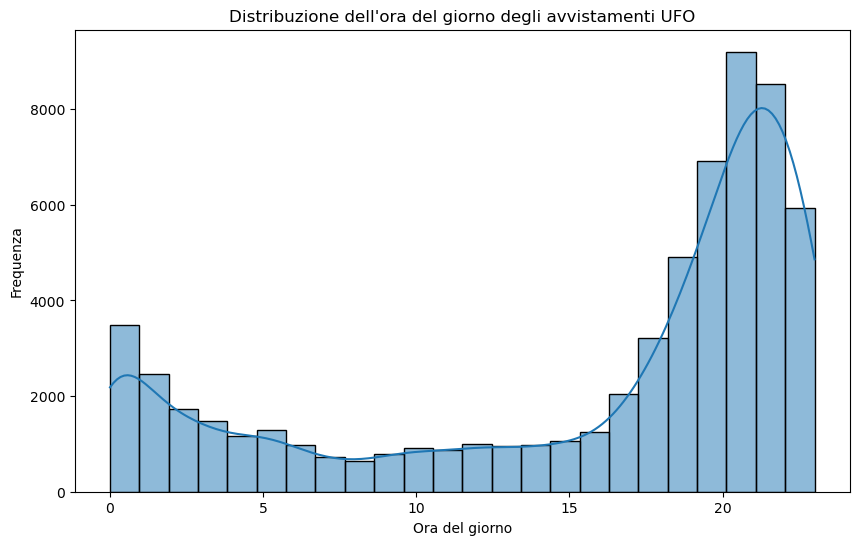

In [17]:
orario = pd.to_datetime(avv1['datetime'])
avv1['hour'] = orario.dt.hour

plt.figure(figsize=(10, 6))
sns.histplot(avv1['hour'], bins=24, kde=True)
plt.title('Distribuzione dell\'ora del giorno degli avvistamenti UFO')
plt.xlabel('Ora del giorno')
plt.ylabel('Frequenza')
plt.show()

# Forma degli avvistamenti per ora del giorno
Nell'asse x la forma dell'avvistamento, nell'asse y la fascia oraria in cui è stata avvistata la forma.

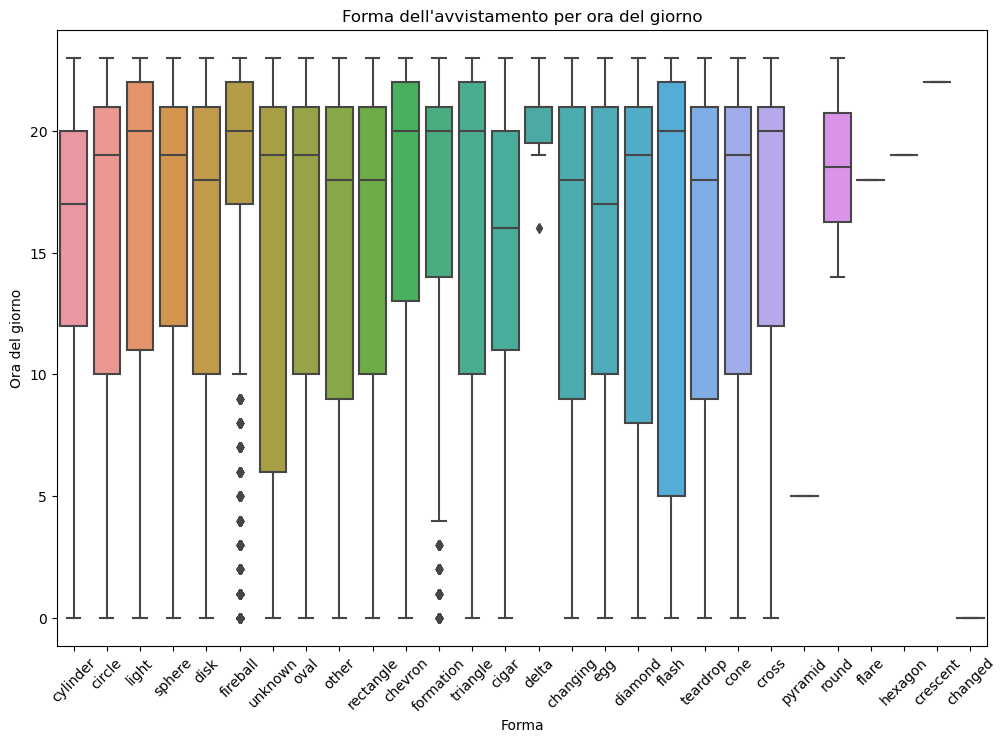

In [18]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='shape', y='hour', data=avv1)
plt.title('Forma dell\'avvistamento per ora del giorno')
plt.xlabel('Forma')
plt.ylabel('Ora del giorno')
plt.xticks(rotation=45)
plt.show()

# Matrice di correlazione
La matrice di correlazione dei dati meteo, latitudine, longitudine, durata.
Possiamo notare correlazioni tra i dati del meteo, e i dati delle posizioni geografiche, non si notano correlazioni tra durata e i dati meteo.

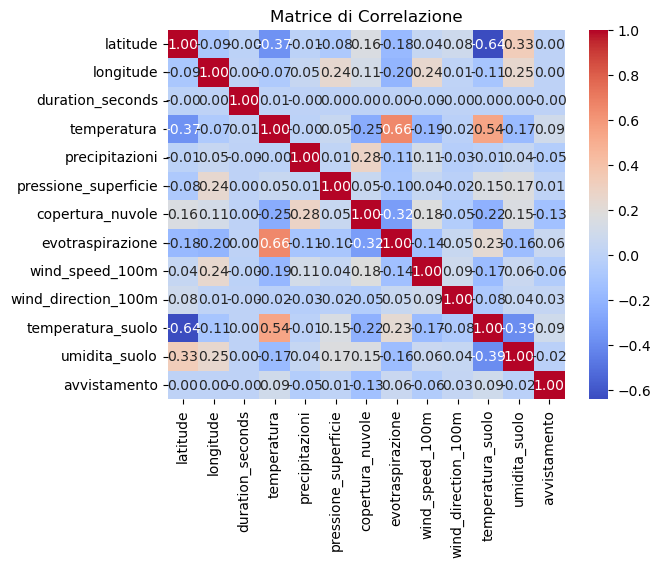

In [19]:
matrice_correlazione = df_ufo[['latitude', 'longitude', 'duration_seconds', 'temperatura', 'precipitazioni', 'pressione_superficie', 'copertura_nuvole', 'evotraspirazione', 'wind_speed_100m', 'wind_direction_100m', 'temperatura_suolo', 'umidita_suolo', 'avvistamento']].corr()

sns.heatmap(matrice_correlazione, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice di Correlazione')
plt.show()

# Test chi-quadro
Il pvalue alto indica che c'è una probabilità molto alta che le differenze tra avvistamento e copertura_nuvole siano dovute dal caso e che le due variabili non siano correlate.  
Di solito, se il p-value è inferiore a un certo valore soglia (solitamente 0.05), si può rigettare l'ipotesi nulla e concludere che esiste un'associazione significativa tra le variabili.
Se il p-value è grande (superiore a 0.05), in questo caso, non ci sono prove statisticamente significative per suggerire che le variabili siano correlate in modo significativo.
In questo esempio il p-value risulta molto alto quindi non si riscontrano correlazioni tra il fatto che ci sia un avvistamento e la copertura delle nuvole.

In [20]:
crosstab = pd.crosstab(df_ufo['avvistamento'], df_ufo['copertura_nuvole'])
chi2_contingency(crosstab)

Chi2ContingencyResult(statistic=2400.597896419, pvalue=0.0, dof=100, expected_freq=array([[14043.04290828,  1953.28565747,  1414.81231406,   886.39449527,
         1144.31870177,   733.55052104,   662.15629624,   678.24513563,
          818.01692785,   563.61215496,   700.36728979,   552.55107788,
          477.63741946,   525.90393763,   670.20071593,   497.24569247,
          649.58689046,   510.8206507 ,   456.52081776,   495.23458754,
          612.8842256 ,   497.24569247,   680.75901678,   507.30121709,
          507.30121709,   506.29566462,   764.72264736,   575.17600827,
          778.2976056 ,  1127.72708615,  1300.17933339,   547.02053934,
          623.44252645,   403.7293135 ,   520.87617532,   399.20432742,
          374.5682921 ,   370.54608225,   461.04580383,   365.51831994,
          491.71515393,   341.88783709,   304.68239599,   316.74902553,
          410.76818073,   318.76013046,   384.62381672,   314.73792061,
          293.11854268,   282.56024183,   361.9988863

# Indice di correlazione di Pearson
- Un coefficiente di correlazione di Pearson vicino a 1 indica una correlazione positiva perfetta, il che significa che le due variabili tendono ad aumentare o diminuire insieme.
- Un coefficiente vicino a -1 indica una correlazione negativa perfetta, il che significa che le due variabili tendono a variare in direzioni opposte.
- Un coefficiente vicino a 0 indica una mancanza di correlazione lineare tra le variabili.

In questo caso tutti i coefficienti in relazione con shape sono prossimi allo 0, questo indica che non c'è una correlazione lineare tra le variabili

In [21]:
dati_num = df_ufo.select_dtypes(include=['float64', 'int64'])
matrice_correlazione = dati_num.corr()
correlazione = matrice_correlazione['avvistamento']

print("Indice di correlazione di Pearson tra 'avvistamento' e le altre colonne:")
print(correlazione)

Indice di correlazione di Pearson tra 'avvistamento' e le altre colonne:
duration_seconds       -0.000193
latitude                0.000781
longitude               0.000250
temperatura             0.094987
precipitazioni         -0.046726
pressione_superficie    0.007519
copertura_nuvole       -0.133235
evotraspirazione        0.062012
wind_speed_100m        -0.055361
wind_direction_100m     0.032293
temperatura_suolo       0.091726
umidita_suolo          -0.019329
avvistamento            1.000000
decennio                0.616031
Name: avvistamento, dtype: float64


# Backword elimination avvistamenti logit

In [22]:
model = logit('avvistamento ~ temperatura + precipitazioni + pressione_superficie + copertura_nuvole + evotraspirazione + wind_speed_100m + wind_direction_100m + temperatura_suolo + umidita_suolo',df_ufo).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.680130
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           avvistamento   No. Observations:               125710
Model:                          Logit   Df Residuals:                   125700
Method:                           MLE   Df Model:                            9
Date:                Mon, 01 Apr 2024   Pseudo R-squ.:                 0.01876
Time:                        14:26:34   Log-Likelihood:                -85499.
converged:                       True   LL-Null:                       -87134.
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.2688      0.131     -2.050      0.040      -0.526      -0.012
temperatura              0.0109      0.001     12.821      0.000       0.009       0.013
precipitazioni          -0.0766      0.014     -5.485      0.000      -0.104      -0.049
pressione_superficie -8.692e-05      0.000     -0.633      0.527      -0.000       0.000
copertura_nuvole        -0.0063      0.000    -34.746      0.000      -0.007      -0.006
evotraspirazione        -0.2454      0.039     -6.260      0.000      -0.322      -0.169
wind_speed_100m         -0.0049      0.001     -7.887      0.000      -0.006      -0.004
wind_direction_100m      0.0007   5.98e-05     12.051      0.000       0.001       0.001
temperatura_suolo        0.0152      0.001     13.187      0.000       0.013       0.017
umidita_suolo            0.5042      0.066      7.620      0.000       0.374       0.634
========================================================================================
"""

L'esponenziale del coefficiente della variabile pressione_superficia è prossimo a 1, questo significa che l'influenza è molto bassa

In [23]:
coeff = model.params
exp_coeff = np.exp(coeff)
print("Esponente dei coefficienti:", exp_coeff)

Esponente dei coefficienti: Intercept               0.764325
temperatura             1.010963
precipitazioni          0.926231
pressione_superficie    0.999913
copertura_nuvole        0.993742
evotraspirazione        0.782413
wind_speed_100m         0.995160
wind_direction_100m     1.000721
temperatura_suolo       1.015303
umidita_suolo           1.655586
dtype: float64


In [24]:
model = logit('avvistamento ~ temperatura + precipitazioni + copertura_nuvole + evotraspirazione + wind_speed_100m + wind_direction_100m + temperatura_suolo + umidita_suolo',df_ufo).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.680131
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           avvistamento   No. Observations:               125710
Model:                          Logit   Df Residuals:                   125701
Method:                           MLE   Df Model:                            8
Date:                Mon, 01 Apr 2024   Pseudo R-squ.:                 0.01876
Time:                        14:26:34   Log-Likelihood:                -85499.
converged:                       True   LL-Null:                       -87134.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.3487      0.035     -9.867      0.000      -0.418      -0.279
temperatura             0.0109      0.001     12.806      0.000       0.009       0.013
precipitazioni         -0.0764      0.014     -5.470      0.000      -0.104      -0.049
copertura_nuvole       -0.0063      0.000    -34.794      0.000      -0.007      -0.006
evotraspirazione       -0.2427      0.039     -6.228      0.000      -0.319      -0.166
wind_speed_100m        -0.0049      0.001     -7.942      0.000      -0.006      -0.004
wind_direction_100m     0.0007   5.98e-05     12.054      0.000       0.001       0.001
temperatura_suolo       0.0150      0.001     13.335      0.000       0.013       0.017
umidita_suolo           0.4944      0.064      7.683      0.000       0.368       0.621
=======================================================================================
"""

# Esponenziale coefficienti
Dall'analisi dell'esponenziale dei coefficienti si evince che il valore che contribuisce in maniera più significativa alla regressione logistica è il valore di umidità del suolo. 

Il valore di umidità del suolo preso ad un'altezza compresa tra i 100cm e i 255cm (altezza uomo), l'unità di misura è m^3 / m^3 ed indica la frazione di volume del suolo occupata dall'acqua rispetto al volume totale del suolo. 
Per esempio, un valore di 0.3 m^3/m^3 significa che il 30% del volume del suolo è costituito da acqua.

Per maggiori informazioni consultare [API Meteo](https://open-meteo.com/en/docs/historical-weather-api).

In [25]:
coeff = model.params
esp_coeff = np.exp(coeff)
print("Esponente dei coefficienti:", esp_coeff)

Esponente dei coefficienti: Intercept              0.705588
temperatura            1.010937
precipitazioni         0.926447
copertura_nuvole       0.993737
evotraspirazione       0.784523
wind_speed_100m        0.995136
wind_direction_100m    1.000721
temperatura_suolo      1.015153
umidita_suolo          1.639533
dtype: float64


# Grafico probabilità predette
Si mette nell'asse x il numero dell'osservazione e nell'asse y mettiamo la probabilità predetta dal regressore logistico, se il valore è superiore a 0,5 allora è più probabile che l'avvistamento sia quello reale presente nel dataset degli avvistamenti, mentre se il valore è sotto 0,5.
Si può notare che gli avvistamenti tendono a mantenersi sopra lo 0,5 mentre i non avvistamenti sotto lo 0,5, quindi è possibile dalle condizioni meteo riuscire a determinare se si tratta di un avvistamento o di un falso.
Raggruppando le medie predette degli avvistamenti e non avvistamenti, notiamo un valore medio superiore a 0,5 negli avvistamenti e inferiore allo 0,5 nei non avvistamenti

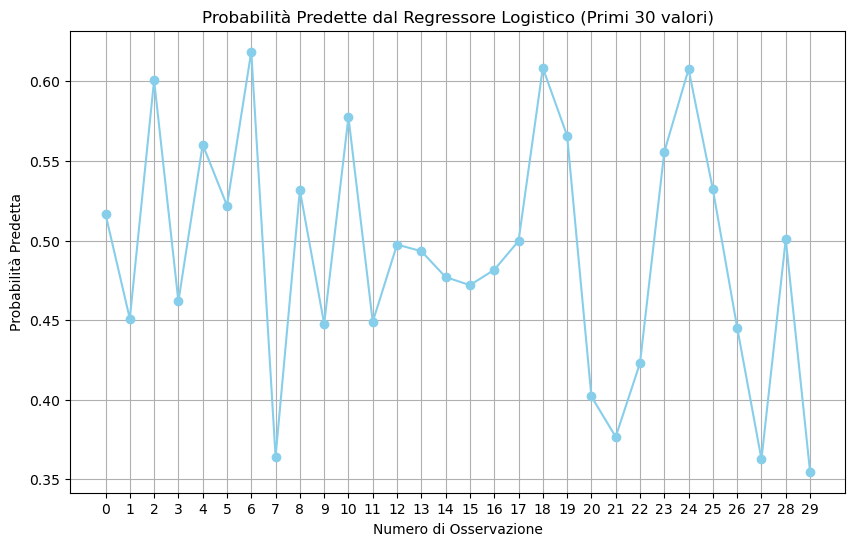

In [26]:
k = 30
probs = model.predict(df_ufo)[:k]

plt.figure(figsize=(10, 6))
plt.plot(range(0, k), probs, marker='o', color='skyblue', linestyle='-')
plt.title('Probabilità Predette dal Regressore Logistico (Primi {} valori)'.format(k))
plt.xlabel('Numero di Osservazione')
plt.ylabel('Probabilità Predetta')
plt.xticks(range(0, k))
plt.grid(True)
plt.show()

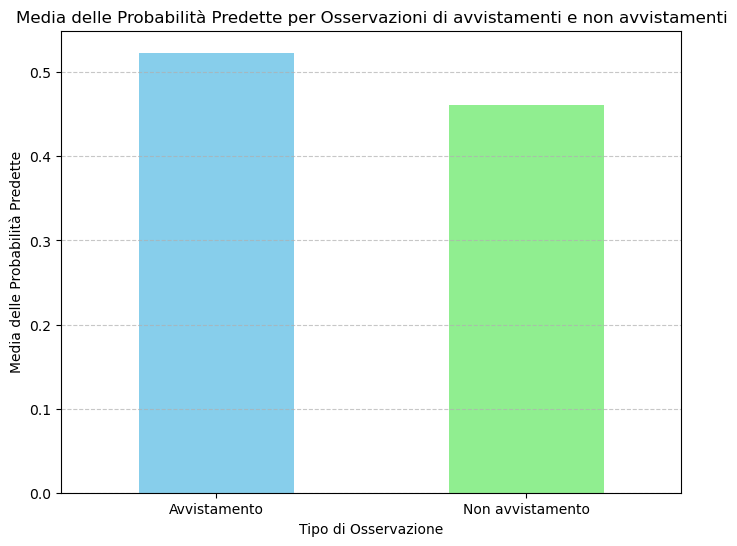

In [27]:
df_predict = pd.DataFrame({'probs': probs, 'indice': range(len(probs))})

probs = df_predict.groupby(df_predict['indice'] % 2)['probs'].mean()

plt.figure(figsize=(8, 6))
probs.plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title('Media delle Probabilità Predette per Osservazioni di avvistamenti e non avvistamenti')
plt.xlabel('Tipo di Osservazione')
plt.ylabel('Media delle Probabilità Predette')
plt.xticks([0, 1], ['Avvistamento', 'Non avvistamento'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Clustering

# Analisi PCA
Variabili con bassa varianza spiegata: Se una variabile ha una bassa varianza spiegata da tutte le componenti principali, potrebbe non contribuire in modo significativo alla struttura dei dati. Si può considerare di scartare queste variabili.

Coefficiente di carico basso: Se una variabile ha un coefficiente di carico basso in tutte le componenti principali, potrebbe non essere rilevante per la struttura complessiva dei dati e potrebbe essere scartata.

In [28]:
colonne = ['temperatura', 'precipitazioni', 'pressione_superficie', 'copertura_nuvole', 
                    'evotraspirazione', 'wind_speed_100m', 'wind_direction_100m', 
                    'temperatura_suolo', 'umidita_suolo']
dati = avv1[colonne]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(dati)

pca = PCA()
pca.fit(data_scaled)

varianza = pca.explained_variance_ratio_
carichi = pca.components_

print("Varianza spiegata da ciascuna componente principale:")
print(varianza)

df_carichi = pd.DataFrame(carichi, columns=colonne)
print("\nCoefficienti di carico delle variabili nelle prime componenti principali:")
print(df_carichi)

variabili_selezionate = ['temperatura', 'precipitazioni', 'pressione_superficie']  

data_cluster = df_ufo[variabili_selezionate]

Varianza spiegata da ciascuna componente principale:
[0.25600478 0.14090262 0.12414201 0.12245144 0.10831601 0.09024136
 0.07649205 0.05514844 0.0263013 ]

Coefficienti di carico delle variabili nelle prime componenti principali:
   temperatura  precipitazioni  pressione_superficie  copertura_nuvole  \
0    -0.534148        0.122119              0.046818          0.329321   
1     0.190438        0.564544              0.384039          0.443714   
2    -0.267304        0.041092             -0.587655          0.050565   
3     0.156674        0.423350             -0.454597          0.202169   
4     0.202796        0.269615             -0.308071          0.152020   
5    -0.099264        0.282419              0.048133          0.072243   
6    -0.138276        0.566218              0.031832         -0.784907   
7    -0.166776        0.103462              0.446968          0.012468   
8    -0.696066        0.041258             -0.017545          0.081695   

   evotraspirazione  wind_spe

# Riduzione dimensionalità PCA
Si esegue una riduzione della dimensionalità utilizzando l'analisi delle componenti principali (PCA) e seleziona le colonne del dataframe df_ufo che contribuiscono a mantenere almeno il 95% della varianza totale.
Le colonne selezionate da questa analisi vengono utilizzate per analisi successive, le variabili che otteniamo sono: 'temperatura', 'precipitazioni', 'pressione_superficie'.

In [29]:
X = avv1[['temperatura', 'precipitazioni', 'pressione_superficie', 'copertura_nuvole', 
            'evotraspirazione', 'wind_speed_100m', 'wind_direction_100m', 
            'temperatura_suolo', 'umidita_suolo']]

pca = PCA()
pca.fit(X)

varianza = pca.explained_variance_ratio_

soglia_varianza = 0.95

varianza_cumulativa = np.cumsum(varianza)
num_componenti_soglia = np.argmax(varianza_cumulativa >= soglia_varianza) + 1

colonne = X.columns[:num_componenti_soglia]

print("Colonne selezionate sulla base della varianza spiegata:")
print(colonne)

Colonne selezionate sulla base della varianza spiegata:
Index(['temperatura', 'precipitazioni', 'pressione_superficie'], dtype='object')


# Clustering sulle varibili selezionate da PCA

C:\Users\dcocu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\dcocu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\dcocu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\dcocu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

Il miglior valore di k è: 2


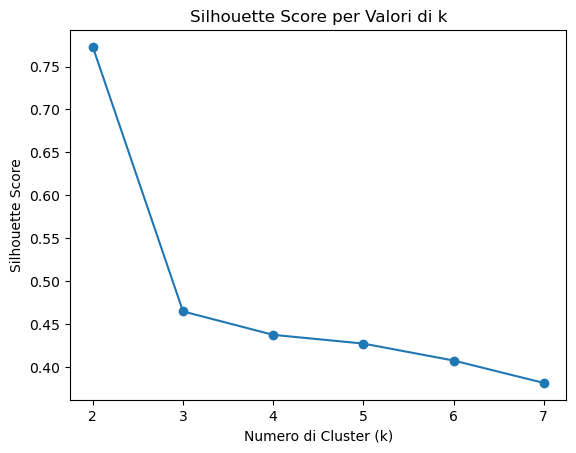

In [30]:
silhouette_scores = []

k = range(2, 8)

for i in k:
    kmeans = KMeans(n_clusters=i)
    labels = kmeans.fit_predict(avv1[['temperatura', 'precipitazioni', 'pressione_superficie']])                                                                                
    silhouette_media = silhouette_score(avv1[['temperatura', 'precipitazioni', 'pressione_superficie']], labels)                                                                                                                                                              
    silhouette_scores.append(silhouette_media)

miglior_k = k[np.argmax(silhouette_scores)]
print("Il miglior valore di k è:", miglior_k)

plt.plot(k, silhouette_scores, marker='o')
plt.xlabel('Numero di Cluster (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score per Valori di k')
plt.show()

C:\Users\dcocu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\dcocu\AppData\Local\Temp\ipykernel_17956\3983174344.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avv1['cluster'] = kmeans.labels_


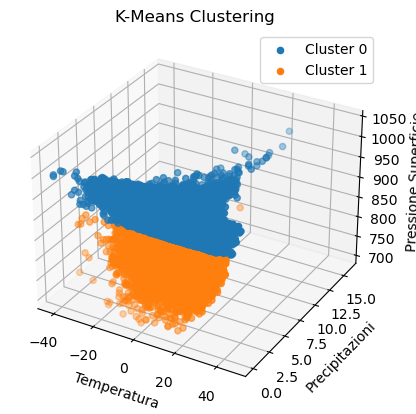

In [31]:
colonne = ['temperatura', 'precipitazioni', 'pressione_superficie']
dati = avv1[colonne]

kmeans = KMeans(n_clusters=2)  
kmeans.fit(dati)

avv1['cluster'] = kmeans.labels_

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for cluster in range(2):
    dati_cluster = avv1[avv1['cluster'] == cluster]
    ax.scatter(dati_cluster['temperatura'], dati_cluster['precipitazioni'], dati_cluster['pressione_superficie'], label=f'Cluster {cluster}')

ax.set_xlabel('Temperatura')
ax.set_ylabel('Precipitazioni')
ax.set_zlabel('Pressione Superficie')
ax.set_title('K-Means Clustering')

ax.legend()
plt.show()

In [32]:
for cluster in range(2):
    dati_cluster = avv1[avv1['cluster'] == cluster]
    media_precipitazioni = dati_cluster['precipitazioni'].mean()
    print(f"Media delle precipitazioni per il cluster {cluster}: {media_precipitazioni}")


Media delle precipitazioni per il cluster 0: 0.07412116942585419
Media delle precipitazioni per il cluster 1: 0.03450925602514845


In [33]:
for cluster in range(2):
    dati_cluster = avv1[avv1['cluster'] == cluster]
    media_temperature = dati_cluster['temperatura'].mean()
    print(f"Media delle temperature per il cluster {cluster}: {media_temperature}")

Media delle temperature per il cluster 0: 17.537321239873197
Media delle temperature per il cluster 1: 16.22509605309116


In [34]:
for cluster in range(2):
    dati_cluster = avv1[avv1['cluster'] == cluster]
    media_pressionesuperficie = dati_cluster['pressione_superficie'].mean()
    print(f"Media delle pressioni superficie per il cluster {cluster}: {media_pressionesuperficie}")

Media delle pressioni superficie per il cluster 0: 997.0453839380064
Media delle pressioni superficie per il cluster 1: 865.7397310513447


<Figure size 1000x600 with 0 Axes>

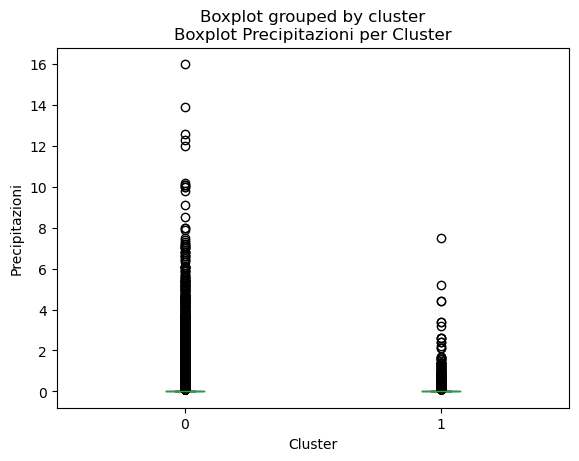

In [35]:
plt.figure(figsize=(10, 6))
avv1.boxplot(column='precipitazioni', by='cluster', grid=False)
plt.title('Boxplot Precipitazioni per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Precipitazioni')
plt.show()

<Figure size 1000x600 with 0 Axes>

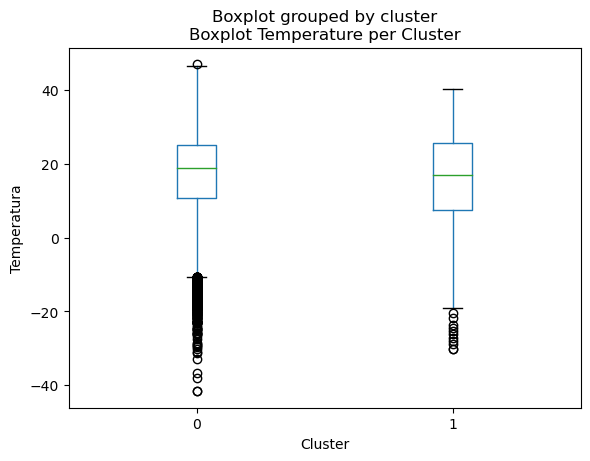

In [36]:
plt.figure(figsize=(10, 6))
avv1.boxplot(column='temperatura', by='cluster', grid=False)
plt.title('Boxplot Temperature per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Temperatura')
plt.show()

<Figure size 1000x600 with 0 Axes>

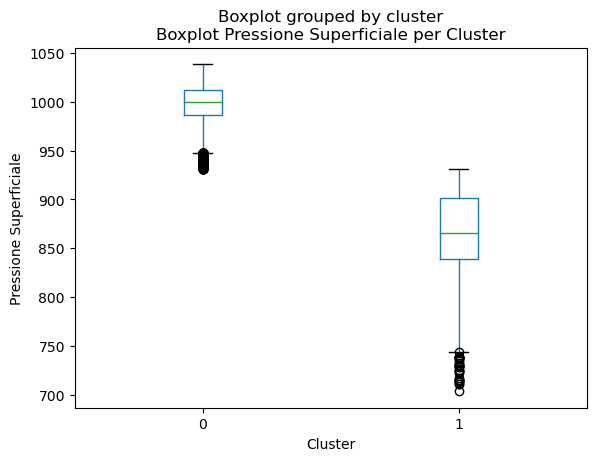

In [37]:
plt.figure(figsize=(10, 6))
avv1.boxplot(column='pressione_superficie', by='cluster', grid=False)
plt.title('Boxplot Pressione Superficiale per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Pressione Superficiale')
plt.show()

# Risultati analisi dei due cluster
Possiamo notare che nel cluster 0 è presente una percentuale di precipitazione più alta e una pressione superficiale più alta mentre la temperatura è simile per entrambi i cluster.

# Conclusioni
È stato preso un dataset contenente i dati degli avvistamenti UFO contenenti le seguenti colonne:
datetime,city,state,country,shape,duration_seconds,duration_hour_min,comments,date_posted,latitude,longitude.
Abbiamo effettuato un'analisi per monitorare l'andamento dei fenomeni UFO negli anni, vedendo quali sono le città, le forme e l'ora del giorno in cui si presentano gli avvistamenti.
La città con più avvistamenti è Seattle mentre la forma più avvistata è una luce, e le ore in cui ci sono più avvistamenti sono le ore notturne. Questo può essere spiegato considerando che durante le ore notturne si possono vedere con più facilità fenomeni luminosi provenienti dallo spazio o dall'atmosfera.

I dati sono stati ampliati cercando tramite la data e le coordinate di latitudine e longitudine i dati metereologici che c'erano durante l'avvistamento, prendendo quelli dell'ora e giorno esatti. Inoltre, per ogni avvistamento è stata creata una seconda riga in cui si registrano i dati meteo di un giorno differente dall'avvistamento.

Si è effettuata una prima analisi esplorativa per conoscere meglio i dati e in seguito si cerca una correlazione tra l'avvistamento e i dati meteo.
È presente una correlazione più forte con i seguenti dati meteo: temperatura, precipitazioni, copertura_nuvole, gli avvistamenti hanno una temperatura maggiore. una minore copertura nuvole, una minore percentuale di precipitazioni e una velocità del vento minore rispetto ai dati meteo dei non avvistamenti.

Abbiamo eseguito una regressione logistica prendendo come variabile dipendente avvistamento e come variabile indipendente i dati meteo e abbiamo fatto una backward elimination scartando le variabili che hanno un alto p-value e abbiamo eliminato il campo pressione_superficie, gli altri campi presentano un p-value prossimo allo 0.
Analizzando i coefficienti della regressione lineare, il coefficiente che ha un effetto più significativo sulla probabilità di avvistamento è l'umidità del suolo.

Dato che gli avvistamenti si verificano spesso nelle ore notturne e che la forma più comune segnalata è una luce e che l'umidità determina l'avvistamento. Si potrebbe ipotizzare che molti avvistamenti potrebbero essere influenzati dall'effetto dell'umidità sull'illuminazione notturna.
L'umidità può alterare la percezione delle luci notturne attraverso fenomeni come la rifrazione e riflessione della luce creando illusioni ottiche alle persone, portandole ad interpretare erroneamente le luci notturne come UFO.

Tramite analisi PCA abbiamo trovato per quali dati si possono raggruppare i dati senza perdere il 95% della varianza totale, sono stati selezionati i seguenti dati: 'temperatura', 'precipitazioni', 'pressione_superficie'e si è effettuato il clustering KMeans.
Tramite il Silhouette Score si è trovato il numero di cluster adatto per effettuare il clustering, si sono suddivisi in 2 cluster ed eseguite analisi sui cluster.
